In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from IPython.display import display, HTML
import logging
import tomotopy as tp
from ast import literal_eval
from pyvis.network import Network
from datetime import datetime as dt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from scipy.interpolate import make_interp_spline

logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
)


In [2]:
# Load UN preprocessed speech
speech = pd.read_csv(
    "Data/Processed/preprocessed_speech.csv",
    index_col=0,
    converters={"Tokens": literal_eval},
)
speech.tail()


,session_nr,year,country,Text,Tokens,Joined_Tokens,Global Code,Global Name,Region Code,Region Name,...,Developed / Developing Countries,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
8493,75,2020,JOR,"in the name of god, the compassionate, the mer...","[name, god, compassionate, merciful, secretary...",name god compassionate merciful secretary inde...,1.0,World,142.0,Asia,...,Developing,4.093992,9.149995,0.708840,67.199997,0.778533,-0.149826,NaN,NaN,NaN
8494,75,2020,BRB,"your excellency, mr. volkan bozkir, i congratu...","[volkan, bozkir, congratulate, turkey, electio...",volkan bozkir congratulate turkey election pre...,1.0,World,19.0,Americas,...,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8495,75,2020,GBR,never in the history of our species — not sinc...,"[never, history, specie, since, almighty, fell...",never history specie since almighty fell tower...,1.0,World,150.0,Europe,...,Developed,6.798177,10.625811,0.929353,72.699997,0.884624,0.202508,0.490204,0.758164,0.224655
8496,75,2020,MCO,"mr. president of the general assembly,\nmr. se...","[lady, gentleman, head, government, lady, gent...",lady gentleman head government lady gentleman ...,1.0,World,150.0,Europe,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8497,75,2020,BHR,"in the name of allah, the most gracious, the m...","[name, allah, gracious, merciful, peace, mercy...",name allah gracious merciful peace mercy bless...,1.0,World,142.0,Asia,...,Developing,6.173176,10.619904,0.847745,69.699997,0.945233,0.132441,NaN,0.789795,0.296835


<h2><center> Dynamic topic modelling <h2><center>

In [3]:
# Let see how the US talks at the UN general debates. Since it is a big dataset, let's get a subset of data
US_speech = speech[
    (speech["Country or Area"] == "United States of America") 
    & (speech["year"] >= 2000)
].reset_index(drop=True)
US_speech

,session_nr,year,country,Text,Tokens,Joined_Tokens,Global Code,Global Name,Region Code,Region Name,...,Developed / Developing Countries,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,55,2000,USA,i am\nhonoured to address the assembly on beha...,"[honour, address, behalf, reinforce, eloquent,...",honour address behalf reinforce eloquent messa...,1.0,World,19.0,Americas,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,2001,USA,we meet in a hall devoted to\npeace; in a city...,"[meet, hall, devote, peace, city, scar, violen...",meet hall devote peace city scar violence nati...,1.0,World,19.0,Americas,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57,2002,USA,we meet one year and one day\nafter a terroris...,"[meet, day, terrorist, attack, brought, grief,...",meet day terrorist attack brought grief brough...,1.0,World,19.0,Americas,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,58,2003,USA,"twenty-four months ago, and\nyesterday in the ...","[month, yesterday, memory, america, centre, yo...",month yesterday memory america centre york cit...,1.0,World,19.0,Americas,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2004,USA,thank you for the honour of\naddressing the ge...,"[honour, address, american, respect, idealism,...",honour address american respect idealism life ...,1.0,World,19.0,Americas,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,60,2005,USA,on behalf\nof president bush and all of the a...,"[behalf, bush, american, york, city, aftermath...",behalf bush american york city aftermath hurri...,1.0,World,19.0,Americas,...,Developed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,61,2006,USA,i am grateful for the privilege of \nspeaking ...,"[grateful, privilege, speak, week, america, ma...",grateful privilege speak week america marked f...,1.0,World,19.0,Americas,...,Developed,7.181794,10.923974,0.964572,68.059998,0.911496,NaN,0.600309,0.827417,0.260511
7,62,2007,USA,thank you for the opportunity \nto address the...,"[opportunity, address, nation, sixty, represen...",opportunity address nation sixty representativ...,1.0,World,19.0,Americas,...,Developed,7.512688,10.933051,NaN,68.220001,0.871904,0.197084,0.633035,0.828503,0.231679
8,63,2008,USA,i am pleased to be here to \naddress the gener...,"[address, representative, around, gather, san,...",address representative around gather san franc...,1.0,World,19.0,Americas,...,Developed,7.280386,10.922226,0.952587,68.379997,0.877956,0.254692,0.668495,0.871968,0.226823
9,64,2009,USA,it is my honour to address the \nassembly for ...,"[honour, address, humble, responsibility, amer...",honour address humble responsibility american ...,1.0,World,19.0,Americas,...,Developed,7.158032,10.887765,0.911794,68.540001,0.830684,0.200643,0.665394,0.843484,0.261661


In [4]:
# prepare data to train dynamic EDL model
def data_feeder(df):
    for index, row in df.iterrows():
        tokens = [token for token in row["Tokens"]]
        yield " ".join(tokens), None, {"timepoint": row["timepoint"]}

US_speech["timepoint"] = US_speech.index
corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer())
corpus.process(data_feeder(US_speech))
print(len(corpus))

21


In [5]:
for i, row in enumerate(data_feeder(US_speech)):
    print(row[0][:50],"...", row[1], row[2])
    if i ==5:
        break


honour address behalf reinforce eloquent message c ... None {'timepoint': 0}
meet hall devote peace city scar violence nation a ... None {'timepoint': 1}
meet day terrorist attack brought grief brought gr ... None {'timepoint': 2}
month yesterday memory america centre york city be ... None {'timepoint': 3}
honour address american respect idealism life orga ... None {'timepoint': 4}
behalf bush american york city aftermath hurricane ... None {'timepoint': 5}


In [6]:
# Train DTM model with 7 topics:
mdl = tp.DTModel(
                 min_cf=3, 
                 k=7, 
                 t=21, 
                 corpus=corpus, 
                 tw=tp.TermWeight.IDF, 
                 seed=0
                 )
# 100 iterations where model goes through the whole corpus 100 times
mdl.train(100)

/var/folders/ny/x98qxh1124dbtz5g3f6s09hh0000gn/T/ipykernel_85625/1327597739.py:11: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



In [27]:
# create an empty DataFrame to store the results
df_results = pd.DataFrame(columns=["topic", "timepoint", "word", "probability"])

for t in range(mdl.num_timepoints):
    for k in range(mdl.k):
        # get the top 10 words of the current topic at the current timepoint
        topic_words = mdl.get_topic_words(k, timepoint=t, top_n=10)
        for word, prob in topic_words:
            # add the word and its probability to the DataFrame
            df_results = pd.concat(
                [
                    df_results,
                    pd.DataFrame(
                        {"topic": k, "timepoint": t, "word": word, "probability": prob},
                        index=[0],
                    ),
                ],
                ignore_index=True,
            )
df_results = df_results.merge(
    US_speech.reset_index(), left_on="timepoint", right_on="index"
)[["topic", "year", "word", "probability"]]
df_results

,topic,year,word,probability
0,0,2000,adjustment,0.014211
1,0,2000,surely,0.011802
2,0,2000,ease,0.011794
3,0,2000,element,0.011788
4,0,2000,silent,0.010093
...,...,...,...,...
1465,6,2020,fast,0.028104
1466,6,2020,domestic,0.028104
1467,6,2020,breakthrough,0.024362
1468,6,2020,cuba,0.021299


In [28]:
df_filtered = df_results.groupby(['topic', 'year']).apply(lambda x: x.nlargest(10, 'probability'))
df_filtered = df_filtered.reset_index(drop=True)
df_pivoted = df_filtered.pivot_table(index=['topic', 'word'], columns='year', values='probability')
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)
df_pivoted = df_pivoted.reset_index().rename_axis(None, axis=1)


/var/folders/ny/x98qxh1124dbtz5g3f6s09hh0000gn/T/ipykernel_85625/881849878.py:1: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [33]:
df_years = []
df_topic_word = pd.DataFrame()
for topic in df_results.topic.unique():
    df_topic = pd.DataFrame()
    for year in df_results.year.unique():
        df_year = (
            df_pivoted[(df_pivoted.topic == topic) & (df_pivoted[year].notnull())][
                ["topic", "word"]
            ]
            .rename({"word": year}, axis=1)
            .reset_index(drop=True)
        )
        df_topic["topic"] = topic
        df_topic[year] = df_year[year]
        df_years.append(df_year)
    df_topic_word = pd.concat([df_topic_word, df_topic])

df_topic_word

,topic,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,adjustment,adjustment,agent,army,asset,builder,approve,alleviate,account,...,aspiration,benghazi,carnage,challenged,carnage,collapse,denuclearization,cycle,activist,carbon
1,0,burma,asset,broken,assist,aung,commission,equally,article,actively,...,bin,bin,community,counter,cuban,cure,diverse,embarrassment,chinese,contrast
2,0,ease,distant,challenged,dedicate,ceasefire,disaster,inspire,education,connect,...,gay,chris,fragile,degrade,goodness,enhances,domination,forever,harmony,drug
3,0,element,holocaust,horror,expertise,difficulty,distort,neutral,environmental,cross,...,israeli,cling,interim,distract,immigrant,framework,duty,horrible,illegal,dump
4,0,expert,hostility,kuwait,export,disrupt,few,oppress,hateful,impact,...,knew,cultural,limited,hate,isil,globalization,earth,icc,magnificent,isi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6,peacekeeper,isolation,kuwait,lethal,draft,enact,outstanding,malaria,instability,...,negotiate,politics,libya,problem,russia,model,maduro,horrible,kingdom,eliminate
6,6,poorest,murderer,little,outlaw,exploitation,lay,peer,moderate,multilateral,...,preferable,slander,match,proxy,simple,myanmar,present,manufacturing,micron,fast
7,6,rapidly,pakistani,saddam,proliferation,monterrey,leadership,propaganda,sector,number,...,shortcut,syrian,rouhani,rapidly,ukraine,ordinary,socialism,migration,please,immediately
8,6,scope,passing,subvert,sex,nigeria,oppose,sixty,thirdly,renew,...,square,video,slaughter,scientist,vacuum,retreat,socialist,successfully,wto,persecution


In [31]:
# manually selected terms for each topic

top_words = {
    0: [
        "judge",
        "ceasefire",
        "peril",
        "patriotism",
        "catastrophe",
        "palestine",
        "plight",
        "patriot",
    ],
    1: ["kuwait", 
        "recession", 
        "labour", 
        "haiti", 
        "hamas", 
        "legal", 
        "inspector"
    ],
    2: [
        "bush",
        "outbreak",
        "burma",
        "sympathy",
        "francisco",
        "incentive",
        "capability",
    ],
    3: ["virus", 
        "vaccine", 
        "wag", 
        "liberia", 
        "venezuela", 
        "lebanese", 
        "kuwait"
    ],
    4: [
        "emergence",
        "sovereignty",
        "army",
        "coexist",
        "square",
        "willingness",
        "presence",
    ],
    5: ["waste",
         "arsenal", 
         "risk", 
         "cripple", 
         "accountability", 
         "symptom", 
         "valley"
    ],
    6: [
        "palestine",
        "sponsor",
        "tyranny",
        "ukraine",
        "exploitation",
        "article",
        "cuba",
        "persecution",
    ],
}

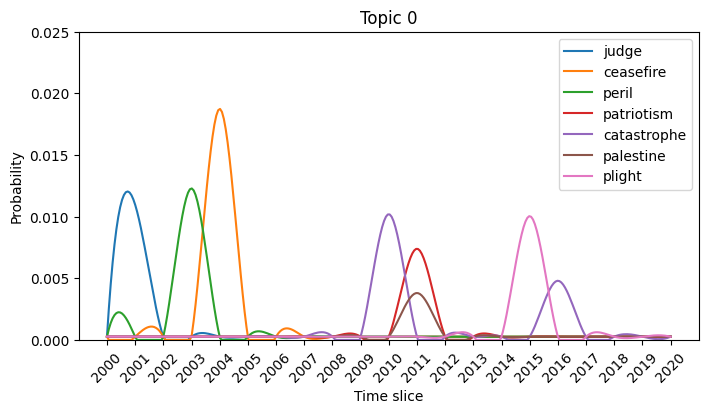

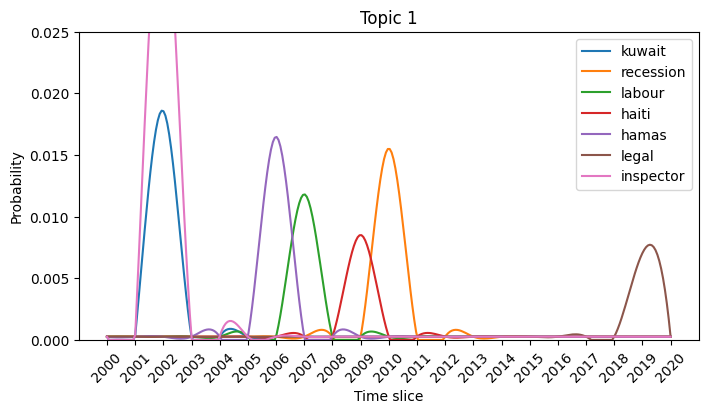

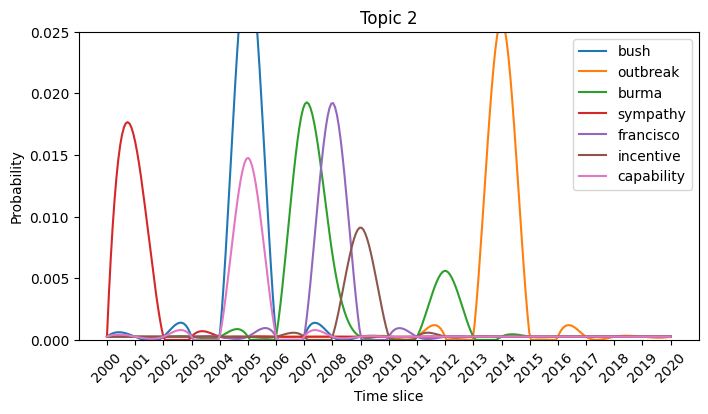

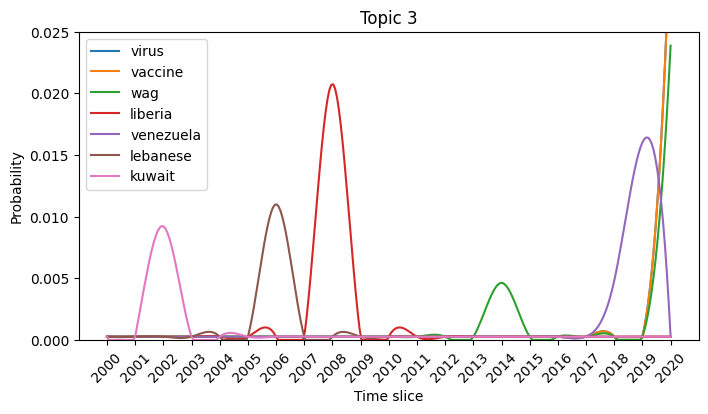

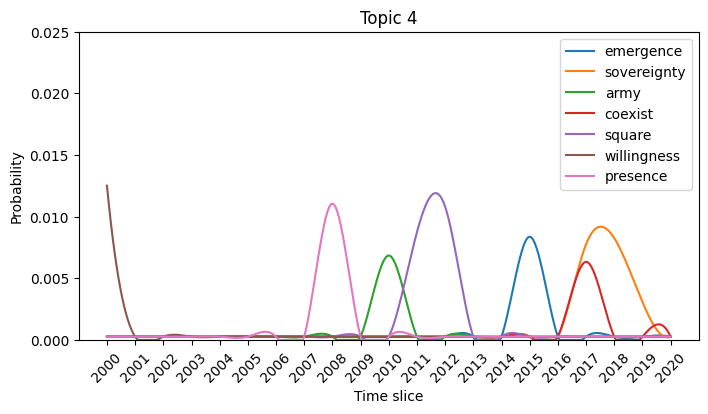

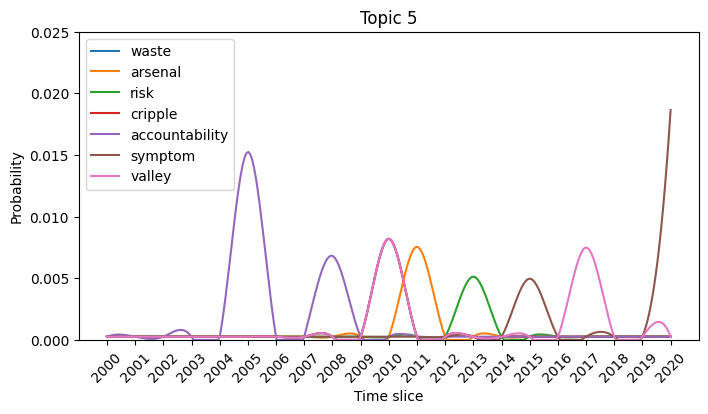

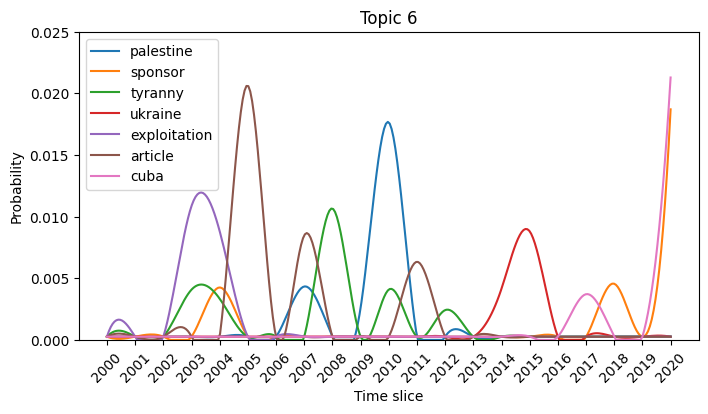

In [34]:
num_top_words = len(top_words[0])
num_timepoints = mdl.num_timepoints
num_topics = mdl.k

# plot the evolution of word probabilities over time for each topic and word
for topic in range(num_topics):
    fig, ax = plt.subplots(figsize=(8, 4))
    for i in range(num_topics):
        word = top_words[topic][i]
        topic_word_probs = []
        for timeslice in range(num_timepoints):
            topic_word_dist = mdl.get_topic_word_dist(topic, timeslice)
            word_index = list(mdl.used_vocabs).index(word)
            topic_word_probs.append(topic_word_dist[word_index])
        # use a spline to smooth the data
        x_smooth = np.linspace(0, num_timepoints-1, 300)
        y_smooth = make_interp_spline(range(num_timepoints), topic_word_probs)(x_smooth)
        y_smooth = np.maximum(y_smooth, 0)
        ax.plot(
            x_smooth,
            y_smooth,
            label=f"{word}"
        )

        ax.legend()
        ax.set_xlabel("Time slice")
        ax.set_ylabel("Probability")
        ax.set_title(f"Topic {topic}")
    ax.set_ylim(0,0.025)
    pos = np.arange(0,21)
    labels = np.arange(2000, 2021)
    ax.set_xticks(pos)
    ax.set_xticklabels(labels, rotation = 45)
    
plt.show()


In [35]:
topic_dist_by_time = np.zeros(shape=[mdl.num_timepoints, mdl.k], dtype=float)
for doc in mdl.docs:
    topic_dist_by_time[doc.timepoint] += doc.get_topic_dist()
topic_dist_by_time /= mdl.num_docs_by_timepoint[:, np.newaxis]

df_top_dist = pd.DataFrame(topic_dist_by_time)
df_top_dist.index = US_speech["year"]
df_top_dist

,0,1,2,3,4,5,6
year,,,,,,,
2000,0.142005,0.151124,0.135173,0.152104,0.133679,0.162198,0.123712
2001,0.155397,0.140595,0.127133,0.148240,0.138103,0.146563,0.143965
2002,0.137911,0.164323,0.123085,0.168171,0.153312,0.097217,0.155982
2003,0.136876,0.145784,0.141975,0.161171,0.137643,0.121171,0.155379
2004,0.138673,0.105775,0.155241,0.159117,0.144678,0.115417,0.181098
2005,0.150622,0.166041,0.134548,0.134862,0.153540,0.130316,0.130067
2006,0.130010,0.139949,0.198095,0.134895,0.120101,0.114738,0.162212
2007,0.111427,0.133173,0.139657,0.172427,0.134972,0.121033,0.187307
2008,0.093654,0.129471,0.171807,0.158977,0.124896,0.151588,0.169606


In [36]:
fig = make_subplots()
# create traces for each stack
for i, col in enumerate(df_top_dist.columns):
    trace = go.Scatter(
        x=df_top_dist.index, y=100 * df_top_dist[col], name=str(col), mode="lines", stackgroup="one"
    )
    fig.add_trace(trace)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="",
    yaxis_range=[0, 100],
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)

fig.show()